In [1]:
import os
import random
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from src.train import train, plot_metrics

from src.models.attn_cond_eegnet_subjectFeatures import ConditionedEEGNet
from src.dataset.MI_dataset_single_subject import MI_Dataset
from src.dataset.MI_dataset_single_subject import MI_Dataset as single_subject_dataset
from config.over60 import cfg


from utils.eval import accuracy
from utils.model import print_parameters, print_weights_statistics

%load_ext autoreload
%autoreload 2


Calculate the average signal of each subect

Give this average to the model, to learn from it


In [2]:
###  Calculate USER AVERAGE FEATURE
### TODO HASH CACHE
subject_averages = {}
for subject_id in cfg['data']['subjects']:
    print("Subject ID: ", subject_id)
    # TODO exclude test runs
    runs = cfg['data']['train_runs'][subject_id] + cfg['data']['test_runs'][subject_id]
    dataset = single_subject_dataset(cfg, subject_id, runs=runs)
    subject_average = np.average(dataset.X, axis=0)
    subject_averages[subject_id] = subject_average

Subject ID:  1
Subject ID:  2
Subject ID:  3
Subject ID:  7
Subject ID:  8


In [3]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
train_dataset = MI_Dataset.get_concat_dataset(cfg, split='train', return_subject_id = True, device=device, verbose=False)
train_dataloader = DataLoader(train_dataset, batch_size=cfg['train']['batch_size'], shuffle=True)
print(f"Train dataset: {len(train_dataset)} samples")

test_dataset = MI_Dataset.get_concat_dataset(cfg, split='test', return_subject_id = True, device=device, verbose=False)
test_dataloader = DataLoader(test_dataset, batch_size=cfg['train']['batch_size'], shuffle=False)
print(f"Test dataset: {len(test_dataset)} samples")

Loading dataset from cache\all_subjects_with_id_1-2-3-7-8\train_dataset.pkl...
Train dataset: 1200 samples
Loading dataset from cache\all_subjects_with_id_1-2-3-7-8\test_dataset.pkl...
Test dataset: 240 samples


In [5]:
model = ConditionedEEGNet.from_config(cfg['model'], subject_averages, cfg["data"]["subjects"], device)
print_parameters(model)


eeg_encoder.conv1.weight........ --> 1024
eeg_encoder.bn1.weight.......... --> 16
eeg_encoder.bn1.bias............ --> 16
eeg_encoder.dw_conv1.weight..... --> 704
eeg_encoder.bn2.weight.......... --> 32
eeg_encoder.bn2.bias............ --> 32
eeg_encoder.sep_conv1.weight.... --> 512
eeg_encoder.conv2.weight........ --> 1024
eeg_encoder.bn3.weight.......... --> 32
eeg_encoder.bn3.bias............ --> 32
eeg_bn.embed.weight............. --> 3840
eeg_norm.weight................. --> 384
eeg_norm.bias................... --> 384
eeg_dim_reduction.weight........ --> 6144
eeg_dim_reduction.bias.......... --> 16
subject_encoder.conv1.weight.... --> 128
subject_encoder.bn1.weight...... --> 2
subject_encoder.bn1.bias........ --> 2
subject_encoder.dw_conv1.weight. --> 88
subject_encoder.bn2.weight...... --> 4
subject_encoder.bn2.bias........ --> 4
subject_encoder.sep_conv1.weight --> 64
subject_encoder.conv2.weight.... --> 8
subject_encoder.bn3.weight...... --> 2
subject_encoder.bn3.bias........ 

In [6]:
# Test forward pass
model(*next(iter(train_dataloader))[0]);

In [7]:
loss, val_loss, train_acc, val_acc = train(model, train_dataloader, test_dataloader, cfg['train'])

Epoch 10/100, Loss: 0.88606, Val Loss: 1.07406, Train acc: 72.58%, Test acc: 60.83%
Epoch 20/100, Loss: 0.85304, Val Loss: 1.01575, Train acc: 75.75%, Test acc: 62.08%
Epoch 30/100, Loss: 0.78815, Val Loss: 0.95669, Train acc: 76.58%, Test acc: 62.92%
Epoch 40/100, Loss: 0.78148, Val Loss: 0.95983, Train acc: 79.33%, Test acc: 65.00%
Epoch 50/100, Loss: 0.74197, Val Loss: 0.96872, Train acc: 77.25%, Test acc: 65.00%
Epoch 60/100, Loss: 0.73371, Val Loss: 0.96794, Train acc: 79.92%, Test acc: 61.25%
Epoch 70/100, Loss: 0.73912, Val Loss: 0.93792, Train acc: 78.42%, Test acc: 65.00%
Epoch 80/100, Loss: 0.73302, Val Loss: 0.96073, Train acc: 80.42%, Test acc: 62.50%
Epoch 90/100, Loss: 0.72322, Val Loss: 0.98807, Train acc: 81.42%, Test acc: 62.08%
Epoch 100/100, Loss: 0.75246, Val Loss: 0.97020, Train acc: 82.75%, Test acc: 66.67%
##################################################
Final train loss: 0.7524645140296534
Final val loss: 0.9702019989490509
Final train acc: 82.75%
Final val ac

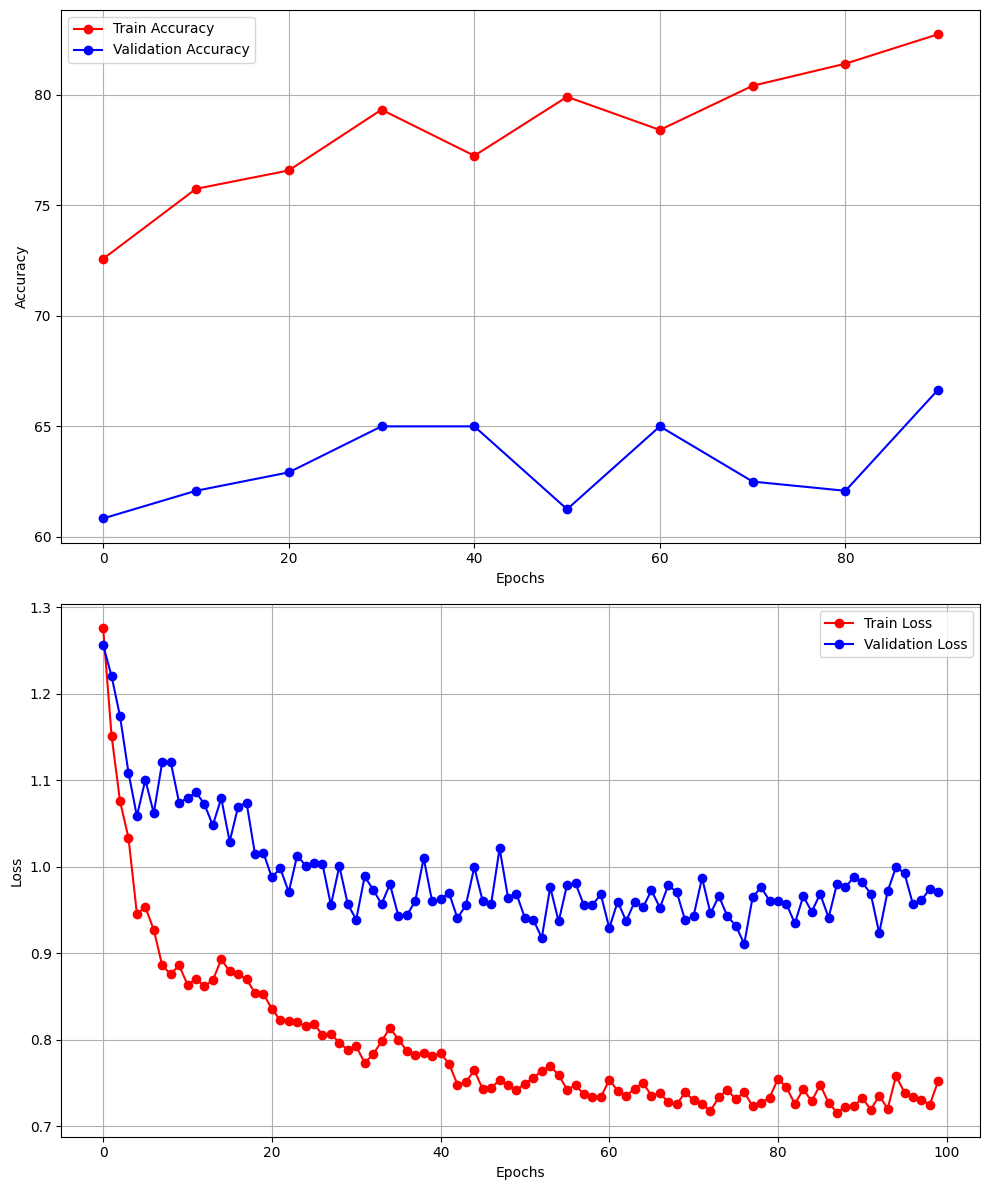

In [8]:
plot_metrics(loss, val_loss, train_acc, val_acc)

In [9]:
individual_results = [62, 60, 74, 78, 60]
average = sum(individual_results)/len(individual_results)
print(average)

66.8
